In [11]:
# data.py
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_data_loaders(base_dir, img_height, img_width, batch_size):
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    train_transforms = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
    test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)

    return train_loader, val_loader, test_loader

In [12]:
# model.py
import torch.nn as nn

class WeatherCNN(nn.Module):
    def __init__(self, img_height, img_width, num_classes=4):
        super(WeatherCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
        )

        final_h = img_height // 8
        final_w = img_width // 8

        self.classifier = nn.Sequential(
            nn.Linear(128 * final_h * final_w, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
# train.py
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.train()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        y_true_train = []
        y_pred_train = []

        model.train()
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

            train_bar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_precision, train_recall, train_f1, _ = calculate_metrics(y_true_train, y_pred_train)

        val_loss, val_acc, y_true_val, y_pred_val = evaluate_model(model, val_loader, criterion, device)
        val_precision, val_recall, val_f1, _ = calculate_metrics(y_true_val, y_pred_val)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'Val Precision: {val_precision:.2f}, Val Recall: {val_recall:.2f}, Val F1: {val_f1:.2f}')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    return model, history

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(data_loader.dataset) if criterion else 0
    acc = 100 * correct / total

    return avg_loss, acc, y_true, y_pred

In [15]:
# utils.py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'])
    ax1.plot(history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    ax2.plot(history['train_loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(model, data_loader, classes, device):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    return y_true, y_pred

def visualize_predictions(model, data_loader, classes, device, num_images=12):
    model.eval()

    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()

    fig = plt.figure(figsize=(15, 10))

    for i in range(num_images):
        ax = fig.add_subplot(3, 4, i + 1)

        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        title_color = 'green' if labels[i] == predicted[i] else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

def predict_image(model, image_path, classes, device, transform):
    from PIL import Image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        _, predicted_idx = torch.max(probabilities, 0)

    predicted_class = classes[predicted_idx.item()]
    confidence = probabilities[predicted_idx].item()

    all_probs = {classes[i]: prob.item() for i, prob in enumerate(probabilities)}

    return {
        'class': predicted_class,
        'confidence': confidence,
        'all_probabilities': all_probs
    }

/Users/hemanth/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cpu


Epoch 1/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.36s/it, loss=2.02, acc=53.8]


Epoch 1/15: Train Loss: 9.1362, Train Acc: 53.76%, Train Precision: 0.53, Train Recall: 0.54, Train F1: 0.53, Val Loss: 2.3417, Val Acc: 56.86%, Val Precision: 0.63, Val Recall: 0.57, Val F1: 0.58


Epoch 2/15 [Train]: 100%|██████████| 23/23 [00:55<00:00,  2.43s/it, loss=4.86, acc=56.1]


Epoch 2/15: Train Loss: 4.8981, Train Acc: 56.13%, Train Precision: 0.56, Train Recall: 0.56, Train F1: 0.56, Val Loss: 3.3446, Val Acc: 57.35%, Val Precision: 0.69, Val Recall: 0.57, Val F1: 0.57


Epoch 3/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.38s/it, loss=3.55, acc=59.9] 


Epoch 3/15: Train Loss: 3.0738, Train Acc: 59.89%, Train Precision: 0.61, Train Recall: 0.60, Train F1: 0.60, Val Loss: 1.9479, Val Acc: 61.76%, Val Precision: 0.63, Val Recall: 0.62, Val F1: 0.62


Epoch 4/15 [Train]: 100%|██████████| 23/23 [00:56<00:00,  2.45s/it, loss=0.514, acc=60.9]


Epoch 4/15: Train Loss: 1.3454, Train Acc: 60.86%, Train Precision: 0.61, Train Recall: 0.61, Train F1: 0.61, Val Loss: 1.8611, Val Acc: 65.20%, Val Precision: 0.74, Val Recall: 0.65, Val F1: 0.65


Epoch 5/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.37s/it, loss=1.04, acc=64.9] 


Epoch 5/15: Train Loss: 1.1439, Train Acc: 64.90%, Train Precision: 0.65, Train Recall: 0.65, Train F1: 0.65, Val Loss: 2.1862, Val Acc: 55.39%, Val Precision: 0.60, Val Recall: 0.55, Val F1: 0.51


Epoch 6/15 [Train]: 100%|██████████| 23/23 [00:56<00:00,  2.46s/it, loss=1.8, acc=62.5]  


Epoch 6/15: Train Loss: 1.1124, Train Acc: 62.53%, Train Precision: 0.63, Train Recall: 0.63, Train F1: 0.63, Val Loss: 2.1831, Val Acc: 59.80%, Val Precision: 0.63, Val Recall: 0.60, Val F1: 0.59


Epoch 7/15 [Train]: 100%|██████████| 23/23 [00:57<00:00,  2.51s/it, loss=1.58, acc=62.7] 


Epoch 7/15: Train Loss: 1.6719, Train Acc: 62.67%, Train Precision: 0.64, Train Recall: 0.63, Train F1: 0.63, Val Loss: 6.0076, Val Acc: 57.35%, Val Precision: 0.59, Val Recall: 0.57, Val F1: 0.53


Epoch 8/15 [Train]: 100%|██████████| 23/23 [01:05<00:00,  2.83s/it, loss=0.958, acc=68.1]


Epoch 8/15: Train Loss: 1.1217, Train Acc: 68.11%, Train Precision: 0.69, Train Recall: 0.68, Train F1: 0.67, Val Loss: 3.4213, Val Acc: 55.39%, Val Precision: 0.55, Val Recall: 0.55, Val F1: 0.51


Epoch 9/15 [Train]: 100%|██████████| 23/23 [00:57<00:00,  2.52s/it, loss=0.754, acc=69.5]


Epoch 9/15: Train Loss: 0.8651, Train Acc: 69.50%, Train Precision: 0.70, Train Recall: 0.69, Train F1: 0.69, Val Loss: 2.7402, Val Acc: 55.88%, Val Precision: 0.55, Val Recall: 0.56, Val F1: 0.52


Epoch 10/15 [Train]: 100%|██████████| 23/23 [01:11<00:00,  3.13s/it, loss=1, acc=67]      


Epoch 10/15: Train Loss: 0.8835, Train Acc: 66.99%, Train Precision: 0.68, Train Recall: 0.67, Train F1: 0.67, Val Loss: 2.5335, Val Acc: 54.90%, Val Precision: 0.54, Val Recall: 0.55, Val F1: 0.51


Epoch 11/15 [Train]: 100%|██████████| 23/23 [01:02<00:00,  2.71s/it, loss=1.66, acc=69.9] 


Epoch 11/15: Train Loss: 0.8915, Train Acc: 69.92%, Train Precision: 0.70, Train Recall: 0.70, Train F1: 0.70, Val Loss: 2.6783, Val Acc: 56.86%, Val Precision: 0.57, Val Recall: 0.57, Val F1: 0.52


Epoch 12/15 [Train]: 100%|██████████| 23/23 [01:20<00:00,  3.51s/it, loss=0.347, acc=70.8]


Epoch 12/15: Train Loss: 0.7807, Train Acc: 70.75%, Train Precision: 0.71, Train Recall: 0.71, Train F1: 0.71, Val Loss: 2.2704, Val Acc: 57.84%, Val Precision: 0.57, Val Recall: 0.58, Val F1: 0.54


Epoch 13/15 [Train]: 100%|██████████| 23/23 [01:02<00:00,  2.73s/it, loss=0.67, acc=68.7] 


Epoch 13/15: Train Loss: 0.7813, Train Acc: 68.66%, Train Precision: 0.69, Train Recall: 0.69, Train F1: 0.69, Val Loss: 2.2837, Val Acc: 56.86%, Val Precision: 0.57, Val Recall: 0.57, Val F1: 0.53


Epoch 14/15 [Train]: 100%|██████████| 23/23 [01:00<00:00,  2.64s/it, loss=0.343, acc=69.9]


Epoch 14/15: Train Loss: 0.7815, Train Acc: 69.92%, Train Precision: 0.71, Train Recall: 0.70, Train F1: 0.70, Val Loss: 2.2898, Val Acc: 56.86%, Val Precision: 0.57, Val Recall: 0.57, Val F1: 0.53


Epoch 15/15 [Train]: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it, loss=0.669, acc=69.2]


Epoch 15/15: Train Loss: 0.8000, Train Acc: 69.22%, Train Precision: 0.71, Train Recall: 0.69, Train F1: 0.69, Val Loss: 2.2907, Val Acc: 56.37%, Val Precision: 0.56, Val Recall: 0.56, Val F1: 0.53
Loaded best model with validation loss: 1.8611


Epoch 1/15 [Train]: 100%|██████████| 23/23 [00:55<00:00,  2.41s/it, loss=1.53, acc=65.7] 


Epoch 1/15: Train Loss: 1.0524, Train Acc: 65.74%, Train Precision: 0.66, Train Recall: 0.66, Train F1: 0.66, Val Loss: 3.4826, Val Acc: 57.35%, Val Precision: 0.60, Val Recall: 0.57, Val F1: 0.55


Epoch 2/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.34s/it, loss=1.37, acc=62]  


Epoch 2/15: Train Loss: 1.4797, Train Acc: 61.98%, Train Precision: 0.65, Train Recall: 0.62, Train F1: 0.63, Val Loss: 2.2530, Val Acc: 60.29%, Val Precision: 0.71, Val Recall: 0.60, Val F1: 0.60


Epoch 3/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it, loss=1.58, acc=52.6] 


Epoch 3/15: Train Loss: 1.2946, Train Acc: 52.65%, Train Precision: 0.56, Train Recall: 0.53, Train F1: 0.53, Val Loss: 3.2906, Val Acc: 58.82%, Val Precision: 0.60, Val Recall: 0.59, Val F1: 0.53


Epoch 4/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it, loss=0.842, acc=58.8]


Epoch 4/15: Train Loss: 1.3877, Train Acc: 58.77%, Train Precision: 0.63, Train Recall: 0.59, Train F1: 0.60, Val Loss: 4.0364, Val Acc: 49.51%, Val Precision: 0.56, Val Recall: 0.50, Val F1: 0.46


Epoch 5/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.31s/it, loss=1.07, acc=54.7] 


Epoch 5/15: Train Loss: 1.1498, Train Acc: 54.74%, Train Precision: 0.60, Train Recall: 0.55, Train F1: 0.56, Val Loss: 4.2117, Val Acc: 50.98%, Val Precision: 0.53, Val Recall: 0.51, Val F1: 0.47


Epoch 6/15 [Train]: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it, loss=0.703, acc=57.9]


Epoch 6/15: Train Loss: 1.0239, Train Acc: 57.94%, Train Precision: 0.65, Train Recall: 0.58, Train F1: 0.59, Val Loss: 3.4398, Val Acc: 50.00%, Val Precision: 0.51, Val Recall: 0.50, Val F1: 0.46


Epoch 7/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.36s/it, loss=0.926, acc=58.2]


Epoch 7/15: Train Loss: 0.9590, Train Acc: 58.22%, Train Precision: 0.69, Train Recall: 0.58, Train F1: 0.60, Val Loss: 3.5357, Val Acc: 50.98%, Val Precision: 0.52, Val Recall: 0.51, Val F1: 0.47


Epoch 8/15 [Train]: 100%|██████████| 23/23 [00:52<00:00,  2.29s/it, loss=0.653, acc=59.6]


Epoch 8/15: Train Loss: 0.9483, Train Acc: 59.61%, Train Precision: 0.67, Train Recall: 0.60, Train F1: 0.61, Val Loss: 3.3851, Val Acc: 51.47%, Val Precision: 0.53, Val Recall: 0.51, Val F1: 0.47


Epoch 9/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.35s/it, loss=0.989, acc=60.2]


Epoch 9/15: Train Loss: 0.9847, Train Acc: 60.17%, Train Precision: 0.68, Train Recall: 0.60, Train F1: 0.62, Val Loss: 3.4686, Val Acc: 51.96%, Val Precision: 0.56, Val Recall: 0.52, Val F1: 0.48


Epoch 10/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.35s/it, loss=1.1, acc=61]    


Epoch 10/15: Train Loss: 0.8985, Train Acc: 61.00%, Train Precision: 0.68, Train Recall: 0.61, Train F1: 0.63, Val Loss: 3.4606, Val Acc: 51.47%, Val Precision: 0.53, Val Recall: 0.51, Val F1: 0.47


Epoch 11/15 [Train]: 100%|██████████| 23/23 [00:57<00:00,  2.50s/it, loss=1.15, acc=58.4] 


Epoch 11/15: Train Loss: 0.9098, Train Acc: 58.36%, Train Precision: 0.66, Train Recall: 0.58, Train F1: 0.60, Val Loss: 3.5540, Val Acc: 51.96%, Val Precision: 0.53, Val Recall: 0.52, Val F1: 0.48


Epoch 12/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it, loss=0.72, acc=59.6] 


Epoch 12/15: Train Loss: 0.9696, Train Acc: 59.61%, Train Precision: 0.68, Train Recall: 0.60, Train F1: 0.61, Val Loss: 3.3101, Val Acc: 51.47%, Val Precision: 0.53, Val Recall: 0.51, Val F1: 0.48


Epoch 13/15 [Train]: 100%|██████████| 23/23 [00:51<00:00,  2.25s/it, loss=1.06, acc=59.9] 


Epoch 13/15: Train Loss: 0.9032, Train Acc: 59.89%, Train Precision: 0.68, Train Recall: 0.60, Train F1: 0.61, Val Loss: 3.3200, Val Acc: 52.45%, Val Precision: 0.54, Val Recall: 0.52, Val F1: 0.48


Epoch 14/15 [Train]: 100%|██████████| 23/23 [00:56<00:00,  2.46s/it, loss=0.491, acc=59.1]


Epoch 14/15: Train Loss: 0.9282, Train Acc: 59.05%, Train Precision: 0.68, Train Recall: 0.59, Train F1: 0.61, Val Loss: 3.3491, Val Acc: 50.98%, Val Precision: 0.53, Val Recall: 0.51, Val F1: 0.47


Epoch 15/15 [Train]: 100%|██████████| 23/23 [00:53<00:00,  2.32s/it, loss=1.09, acc=61.1] 


Epoch 15/15: Train Loss: 0.9420, Train Acc: 61.14%, Train Precision: 0.69, Train Recall: 0.61, Train F1: 0.63, Val Loss: 3.4003, Val Acc: 50.98%, Val Precision: 0.52, Val Recall: 0.51, Val F1: 0.47
Loaded best model with validation loss: 2.2530


Epoch 1/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.37s/it, loss=54.6, acc=50.8]


Epoch 1/15: Train Loss: 60.8068, Train Acc: 50.84%, Train Precision: 0.51, Train Recall: 0.51, Train F1: 0.51, Val Loss: 22.9732, Val Acc: 45.10%, Val Precision: 0.50, Val Recall: 0.45, Val F1: 0.46


Epoch 2/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.38s/it, loss=5.77, acc=57.2]


Epoch 2/15: Train Loss: 11.3798, Train Acc: 57.24%, Train Precision: 0.57, Train Recall: 0.57, Train F1: 0.57, Val Loss: 14.0751, Val Acc: 51.47%, Val Precision: 0.64, Val Recall: 0.51, Val F1: 0.47


Epoch 3/15 [Train]: 100%|██████████| 23/23 [00:57<00:00,  2.50s/it, loss=12.1, acc=60.9]


Epoch 3/15: Train Loss: 4.1310, Train Acc: 60.86%, Train Precision: 0.61, Train Recall: 0.61, Train F1: 0.61, Val Loss: 3.3221, Val Acc: 61.27%, Val Precision: 0.59, Val Recall: 0.61, Val F1: 0.58


Epoch 4/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.38s/it, loss=1.05, acc=59.2] 


Epoch 4/15: Train Loss: 2.2644, Train Acc: 59.19%, Train Precision: 0.61, Train Recall: 0.59, Train F1: 0.60, Val Loss: 3.4291, Val Acc: 51.47%, Val Precision: 0.58, Val Recall: 0.51, Val F1: 0.53


Epoch 5/15 [Train]: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it, loss=0.992, acc=61.7]


Epoch 5/15: Train Loss: 1.8204, Train Acc: 61.70%, Train Precision: 0.63, Train Recall: 0.62, Train F1: 0.62, Val Loss: 2.1616, Val Acc: 57.35%, Val Precision: 0.61, Val Recall: 0.57, Val F1: 0.57


Epoch 6/15 [Train]: 100%|██████████| 23/23 [00:49<00:00,  2.16s/it, loss=0.731, acc=63.5]


Epoch 6/15: Train Loss: 1.4953, Train Acc: 63.51%, Train Precision: 0.64, Train Recall: 0.64, Train F1: 0.63, Val Loss: 1.7824, Val Acc: 64.22%, Val Precision: 0.66, Val Recall: 0.64, Val F1: 0.64


Epoch 7/15 [Train]: 100%|██████████| 23/23 [00:59<00:00,  2.57s/it, loss=0.78, acc=64.2] 


Epoch 7/15: Train Loss: 1.1015, Train Acc: 64.21%, Train Precision: 0.68, Train Recall: 0.64, Train F1: 0.64, Val Loss: 1.5406, Val Acc: 67.16%, Val Precision: 0.68, Val Recall: 0.67, Val F1: 0.67


Epoch 8/15 [Train]: 100%|██████████| 23/23 [00:50<00:00,  2.22s/it, loss=1.14, acc=63.1] 


Epoch 8/15: Train Loss: 0.9646, Train Acc: 63.09%, Train Precision: 0.65, Train Recall: 0.63, Train F1: 0.63, Val Loss: 2.2286, Val Acc: 56.37%, Val Precision: 0.55, Val Recall: 0.56, Val F1: 0.52


Epoch 9/15 [Train]: 100%|██████████| 23/23 [00:55<00:00,  2.42s/it, loss=0.68, acc=62.4] 


Epoch 9/15: Train Loss: 1.1538, Train Acc: 62.40%, Train Precision: 0.64, Train Recall: 0.62, Train F1: 0.62, Val Loss: 1.9975, Val Acc: 55.39%, Val Precision: 0.57, Val Recall: 0.55, Val F1: 0.50


Epoch 10/15 [Train]: 100%|██████████| 23/23 [00:57<00:00,  2.48s/it, loss=0.851, acc=61.3]


Epoch 10/15: Train Loss: 1.1729, Train Acc: 61.28%, Train Precision: 0.64, Train Recall: 0.61, Train F1: 0.62, Val Loss: 1.4878, Val Acc: 66.67%, Val Precision: 0.67, Val Recall: 0.67, Val F1: 0.66


Epoch 11/15 [Train]: 100%|██████████| 23/23 [00:56<00:00,  2.45s/it, loss=3.58, acc=62.8] 


Epoch 11/15: Train Loss: 1.2605, Train Acc: 62.81%, Train Precision: 0.65, Train Recall: 0.63, Train F1: 0.63, Val Loss: 2.0202, Val Acc: 59.80%, Val Precision: 0.59, Val Recall: 0.60, Val F1: 0.59


Epoch 12/15 [Train]: 100%|██████████| 23/23 [00:56<00:00,  2.44s/it, loss=1.03, acc=64.3] 


Epoch 12/15: Train Loss: 1.0633, Train Acc: 64.35%, Train Precision: 0.67, Train Recall: 0.64, Train F1: 0.64, Val Loss: 1.4643, Val Acc: 64.71%, Val Precision: 0.68, Val Recall: 0.65, Val F1: 0.66


Epoch 13/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.37s/it, loss=0.54, acc=62.1] 


Epoch 13/15: Train Loss: 1.0921, Train Acc: 62.12%, Train Precision: 0.65, Train Recall: 0.62, Train F1: 0.62, Val Loss: 1.5879, Val Acc: 62.75%, Val Precision: 0.68, Val Recall: 0.63, Val F1: 0.63


Epoch 14/15 [Train]: 100%|██████████| 23/23 [00:54<00:00,  2.35s/it, loss=0.935, acc=63.6]


Epoch 14/15: Train Loss: 1.1573, Train Acc: 63.65%, Train Precision: 0.65, Train Recall: 0.64, Train F1: 0.63, Val Loss: 1.3611, Val Acc: 65.69%, Val Precision: 0.67, Val Recall: 0.66, Val F1: 0.62


Epoch 15/15 [Train]: 100%|██████████| 23/23 [00:51<00:00,  2.25s/it, loss=1.04, acc=62.8] 


Epoch 15/15: Train Loss: 1.2122, Train Acc: 62.81%, Train Precision: 0.65, Train Recall: 0.63, Train F1: 0.63, Val Loss: 1.7003, Val Acc: 59.80%, Val Precision: 0.63, Val Recall: 0.60, Val F1: 0.58
Loaded best model with validation loss: 1.3611


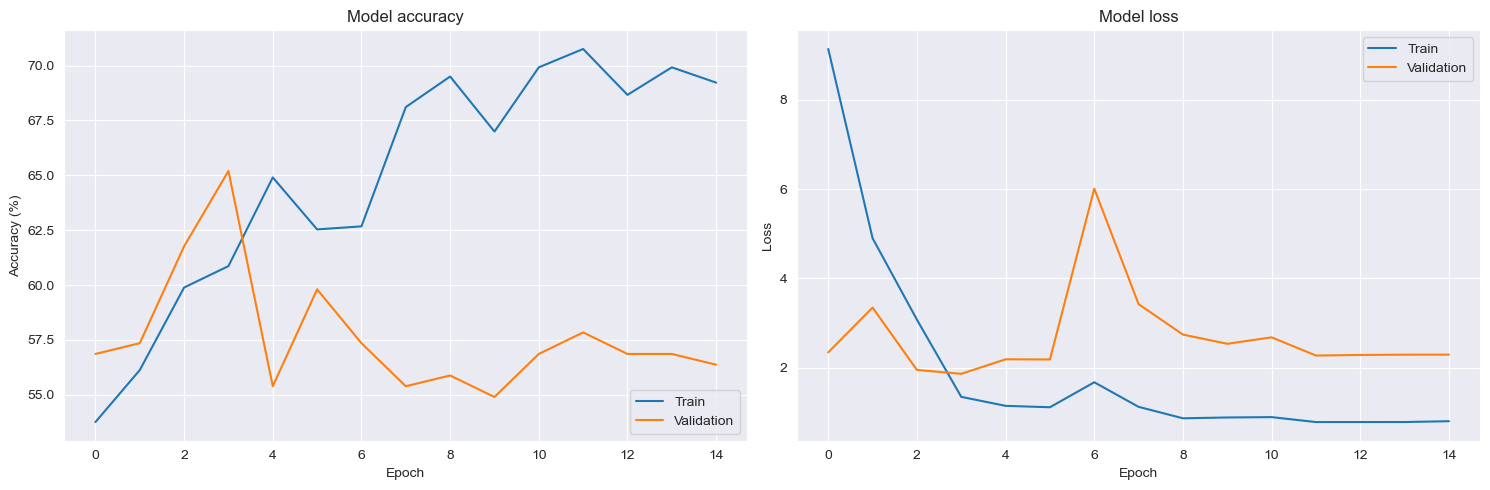

Generating predictions: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


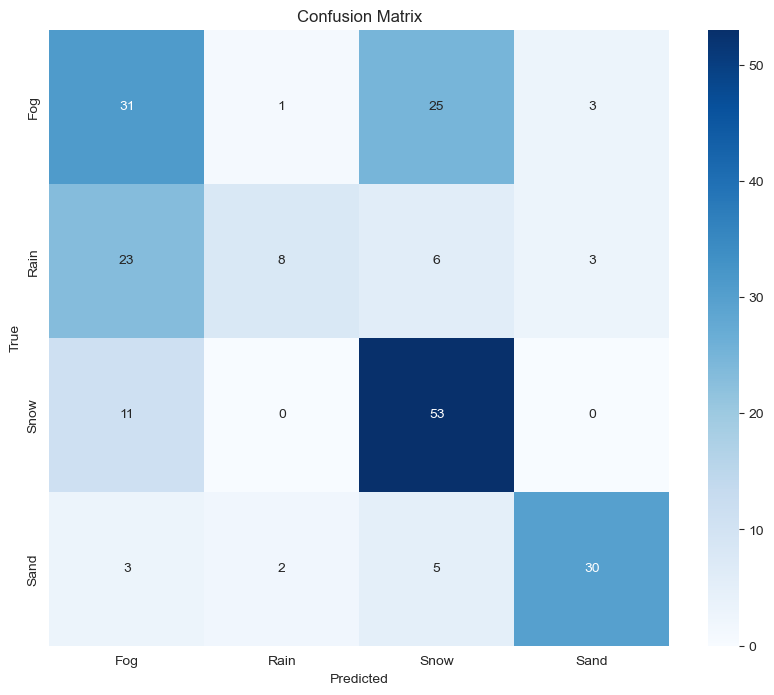


Classification Report:
              precision    recall  f1-score   support

         Fog       0.46      0.52      0.48        60
        Rain       0.73      0.20      0.31        40
        Snow       0.60      0.83      0.69        64
        Sand       0.83      0.75      0.79        40

    accuracy                           0.60       204
   macro avg       0.65      0.57      0.57       204
weighted avg       0.63      0.60      0.58       204



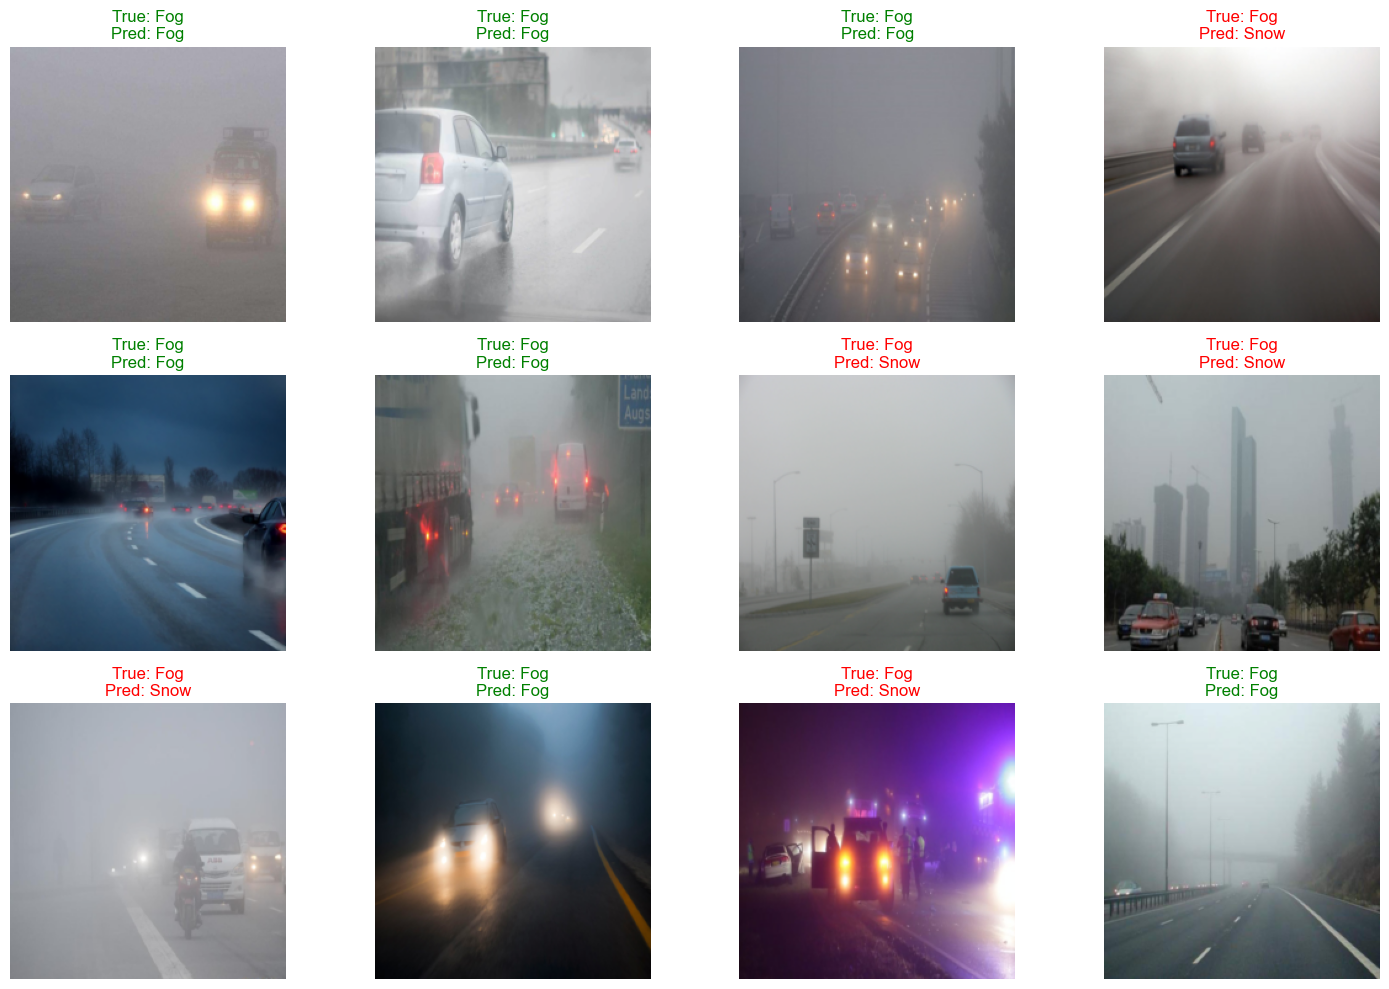

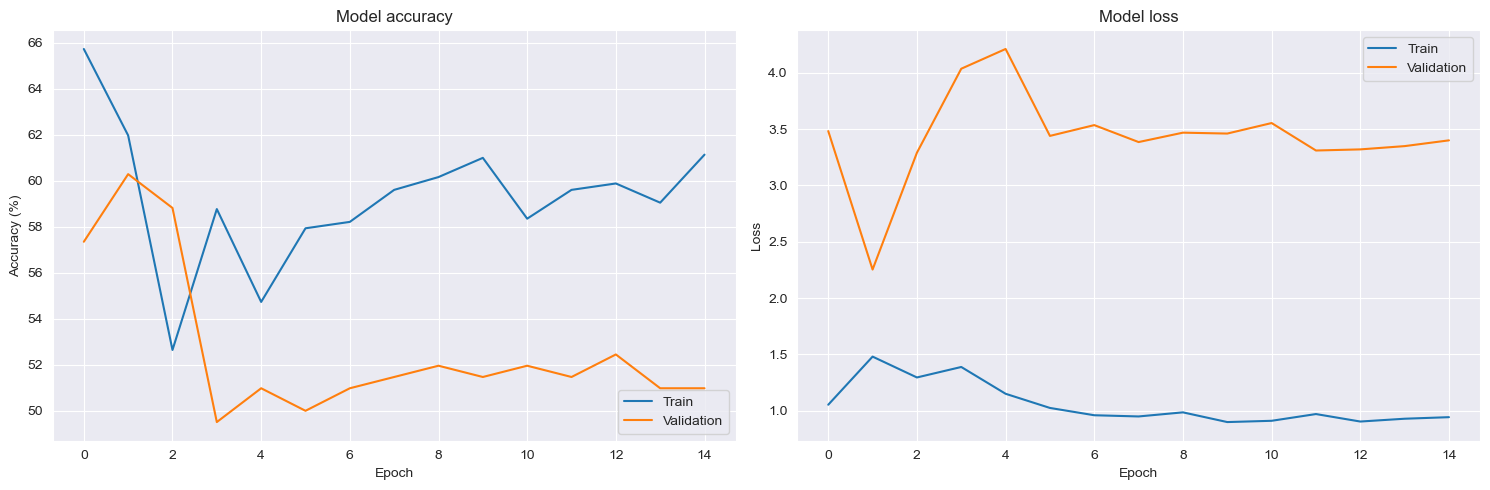

Generating predictions: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


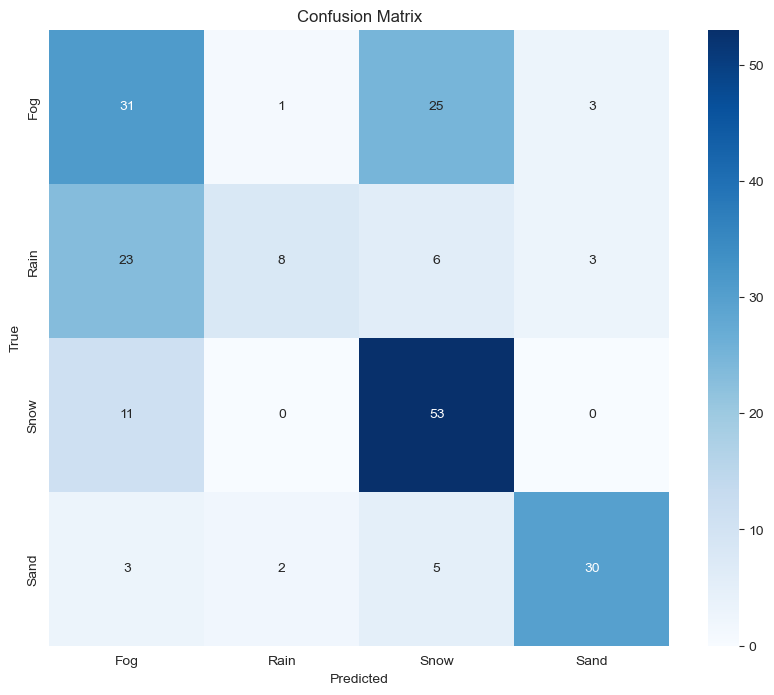


Classification Report:
              precision    recall  f1-score   support

         Fog       0.46      0.52      0.48        60
        Rain       0.73      0.20      0.31        40
        Snow       0.60      0.83      0.69        64
        Sand       0.83      0.75      0.79        40

    accuracy                           0.60       204
   macro avg       0.65      0.57      0.57       204
weighted avg       0.63      0.60      0.58       204



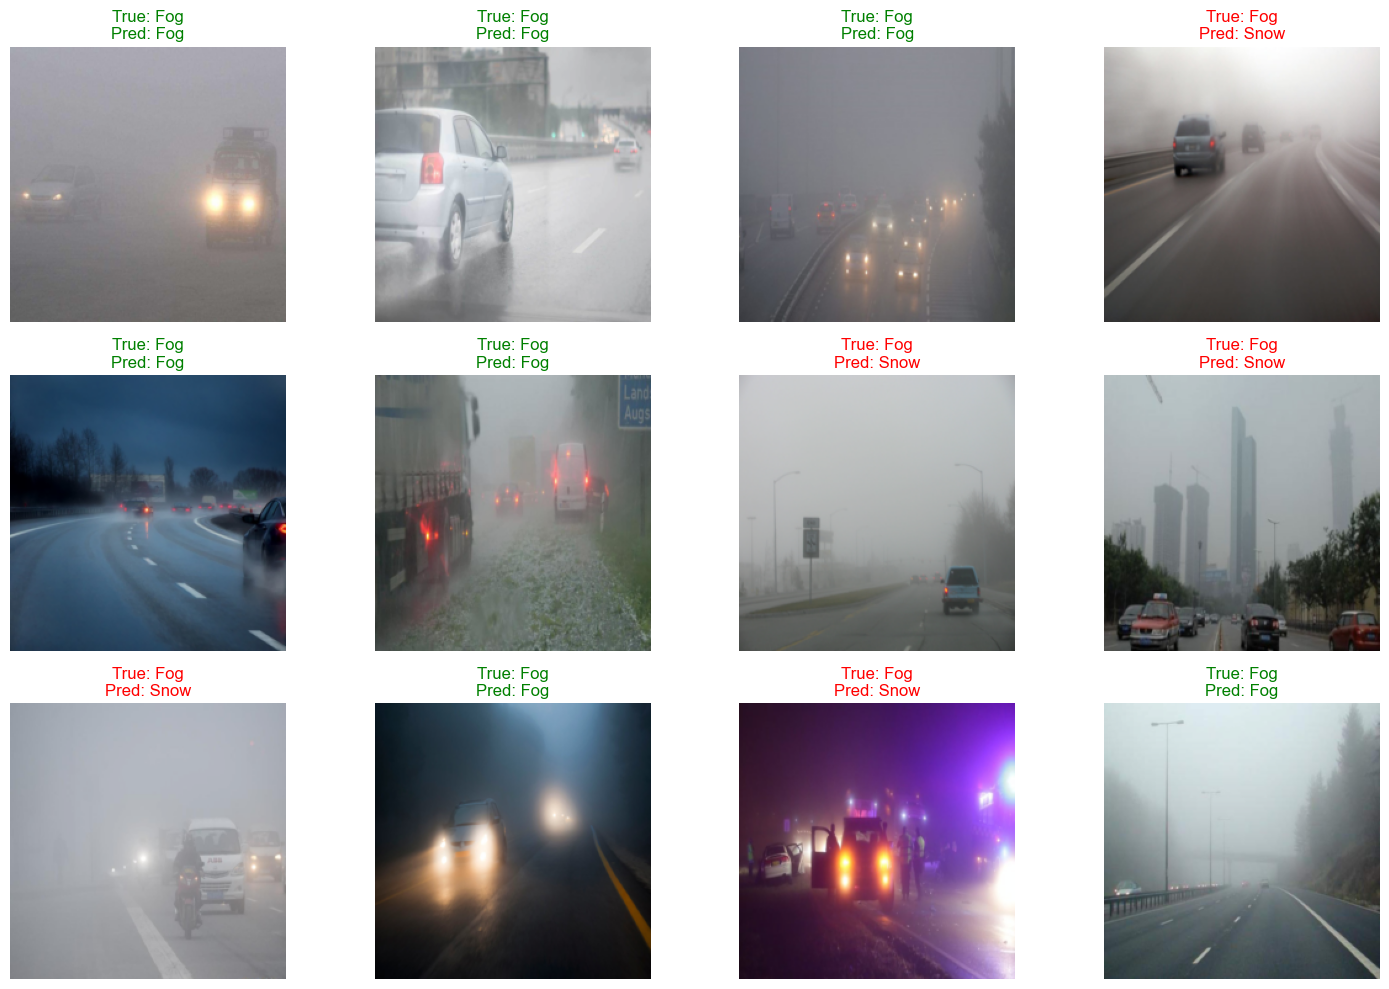

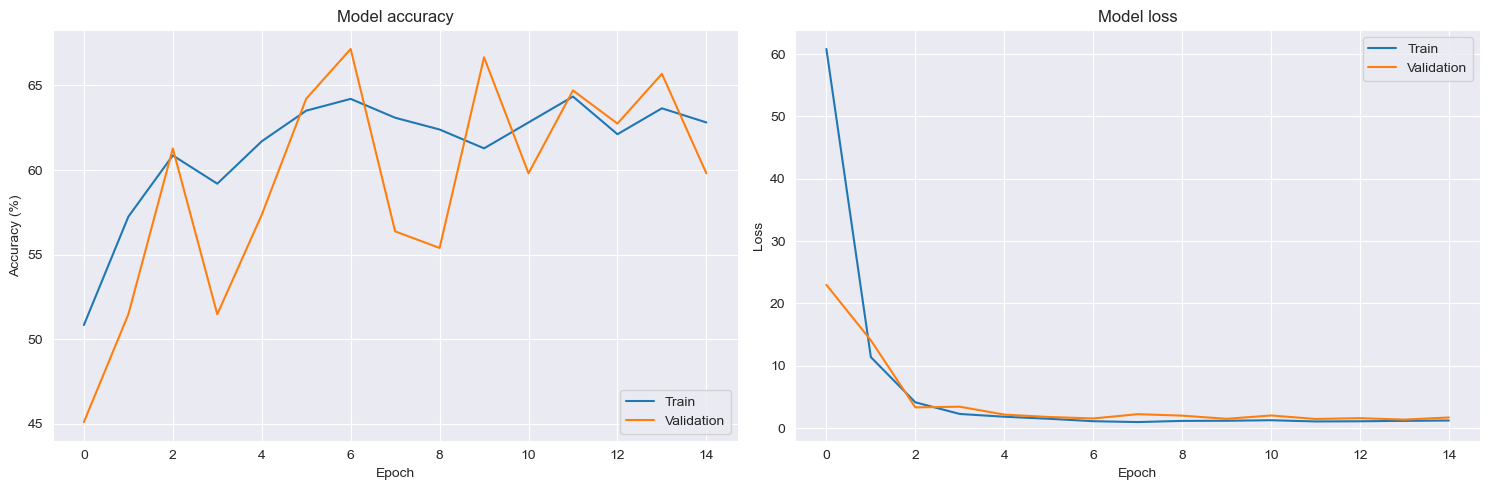

Generating predictions: 100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


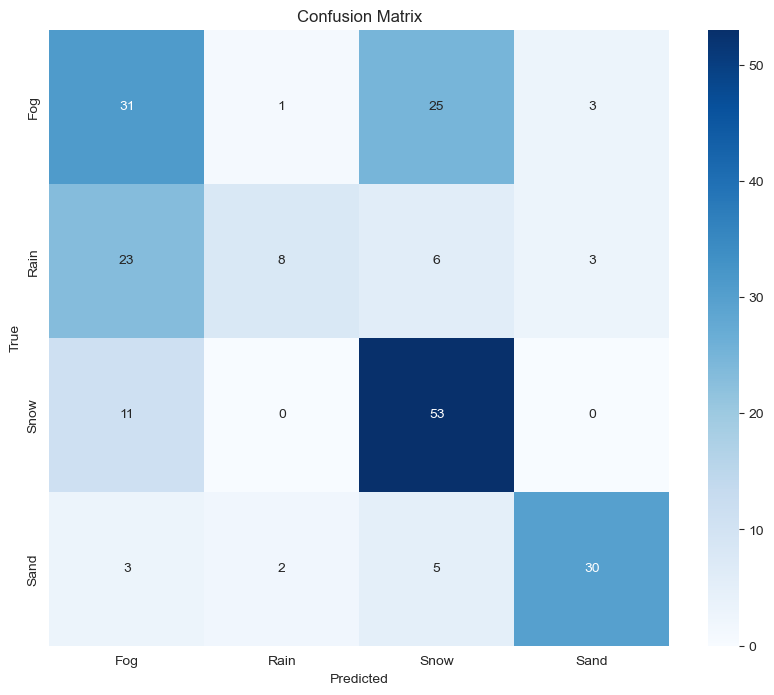


Classification Report:
              precision    recall  f1-score   support

         Fog       0.46      0.52      0.48        60
        Rain       0.73      0.20      0.31        40
        Snow       0.60      0.83      0.69        64
        Sand       0.83      0.75      0.79        40

    accuracy                           0.60       204
   macro avg       0.65      0.57      0.57       204
weighted avg       0.63      0.60      0.58       204



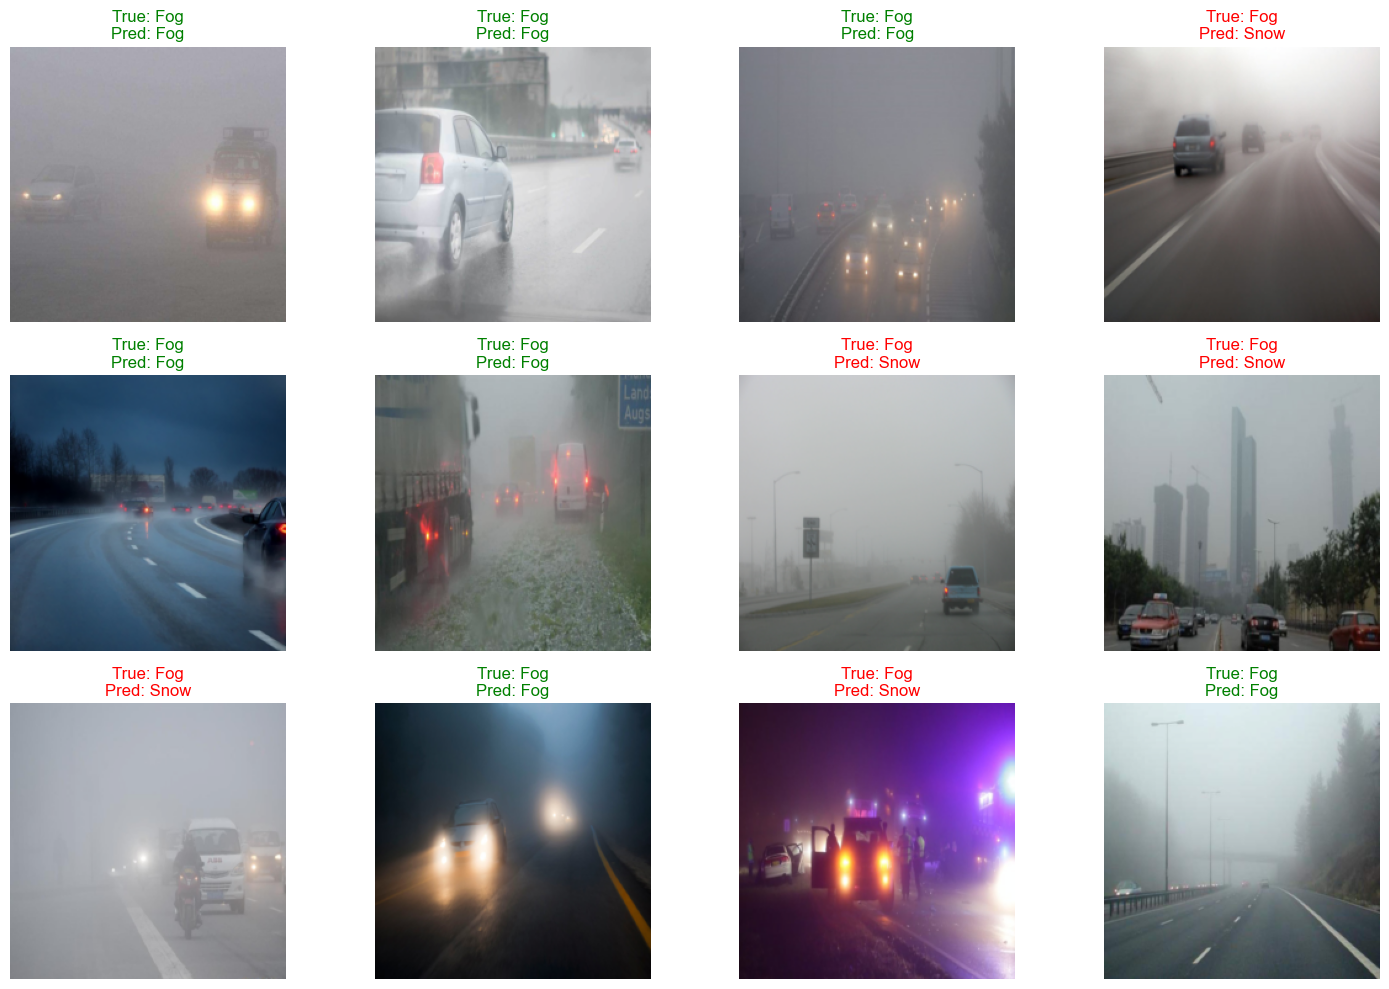

In [17]:
# main.py
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn


# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define paths and parameters
base_dir = '../data/DAWN_processed'
img_height, img_width = 224, 224
batch_size = 32
epochs = 15
learning_rate = 0.001
weight_decay = 1e-4
classes = ['Fog', 'Rain', 'Snow', 'Sand']

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get data loaders
train_loader, val_loader, test_loader = get_data_loaders(base_dir, img_height, img_width, batch_size)

# Instantiate the model
model = WeatherCNN(img_height, img_width, num_classes=len(classes))
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Initialize different optimizers
optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define schedulers
scheduler_adam = optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam, mode='min', factor=0.1, patience=2, verbose=True)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, mode='min', factor=0.1, patience=2, verbose=True)
scheduler_rmsprop = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rmsprop, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model with different optimizers
model_adam, history_adam = train_model(model, train_loader, val_loader, criterion, optimizer_adam, scheduler_adam, epochs, device)
model_sgd, history_sgd = train_model(model, train_loader, val_loader, criterion, optimizer_sgd, scheduler_sgd, epochs, device)
model_rmsprop, history_rmsprop = train_model(model, train_loader, val_loader, criterion, optimizer_rmsprop, scheduler_rmsprop, epochs, device)

# Evaluate and visualize results for Adam optimizer
plot_training_history(history_adam)
plot_confusion_matrix(model_adam, val_loader, classes, device)
visualize_predictions(model_adam, test_loader, classes, device, num_images=12)
torch.save(model_adam.state_dict(), 'weather_cnn_adam.pth')

# Evaluate and visualize results for SGD optimizer
plot_training_history(history_sgd)
plot_confusion_matrix(model_sgd, val_loader, classes, device)
visualize_predictions(model_sgd, test_loader, classes, device, num_images=12)
torch.save(model_sgd.state_dict(), 'weather_cnn_sgd.pth')

# Evaluate and visualize results for RMSprop optimizer
plot_training_history(history_rmsprop)
plot_confusion_matrix(model_rmsprop, val_loader, classes, device)
visualize_predictions(model_rmsprop, test_loader, classes, device, num_images=12)
torch.save(model_rmsprop.state_dict(), 'weather_cnn_rmsprop.pth')